In [208]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from sklearn.linear_model import SGDClassifier

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")

In [209]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [210]:
def normalization(data, feature):
    data[feature] = (data[feature] - data[feature].min()) / (data[feature].max() - data[feature].min())
    return data

In [211]:
def remove_outliers(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5*IQR
    lower_bound = Q1 - 1.5*IQR
    print(IQR)
    print("Upper Limit: ", upper_bound)
    print("Lower Limit: ", lower_bound)
    
    index = data[(data[feature] >= upper_bound)|(data[feature] <= lower_bound)].index
    data.drop(index, inplace=True)
    #data[feature] = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
    return data

In [212]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [213]:
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [214]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [215]:
cat_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
num_cols = ['id', 'Driving_License', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

In [216]:
train['Gender'].replace({'Male':0, 'Female':1}, inplace=True)
test["Gender"].replace({'Male':0, 'Female':1}, inplace=True)

In [217]:
train["Vehicle_Age"].replace({"< 1 Year": 0, "1-2 Year":1, "> 2 Years":3}, inplace=True)
test['Vehicle_Age'].replace({"< 1 Year": 0, "1-2 Year":1, "> 2 Years":3}, inplace=True)

train["Vehicle_Damage"].replace({'Yes': 0, "No":1}, inplace=True)
test['Vehicle_Damage'].replace({'Yes':0, 'No':1}, inplace=True)

In [180]:
train

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,3,0,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,1,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,3,0,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,1,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,1,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,26.0,1,1,1,30170.0,26.0,88,0
381105,381106,0,30,1,37.0,1,0,1,40016.0,152.0,131,0
381106,381107,0,21,1,30.0,1,0,1,35118.0,160.0,161,0
381107,381108,1,68,1,14.0,0,3,0,44617.0,124.0,74,0


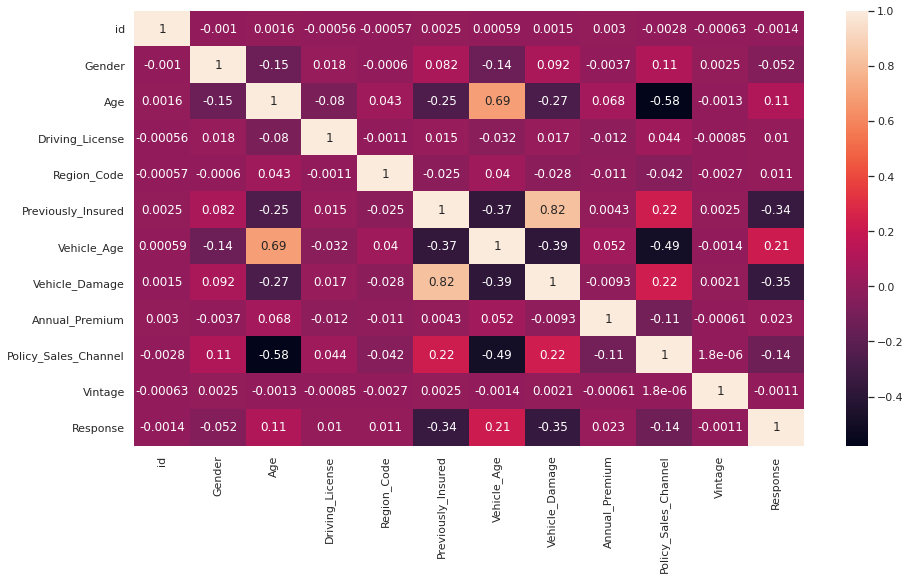

In [181]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(), annot=True)

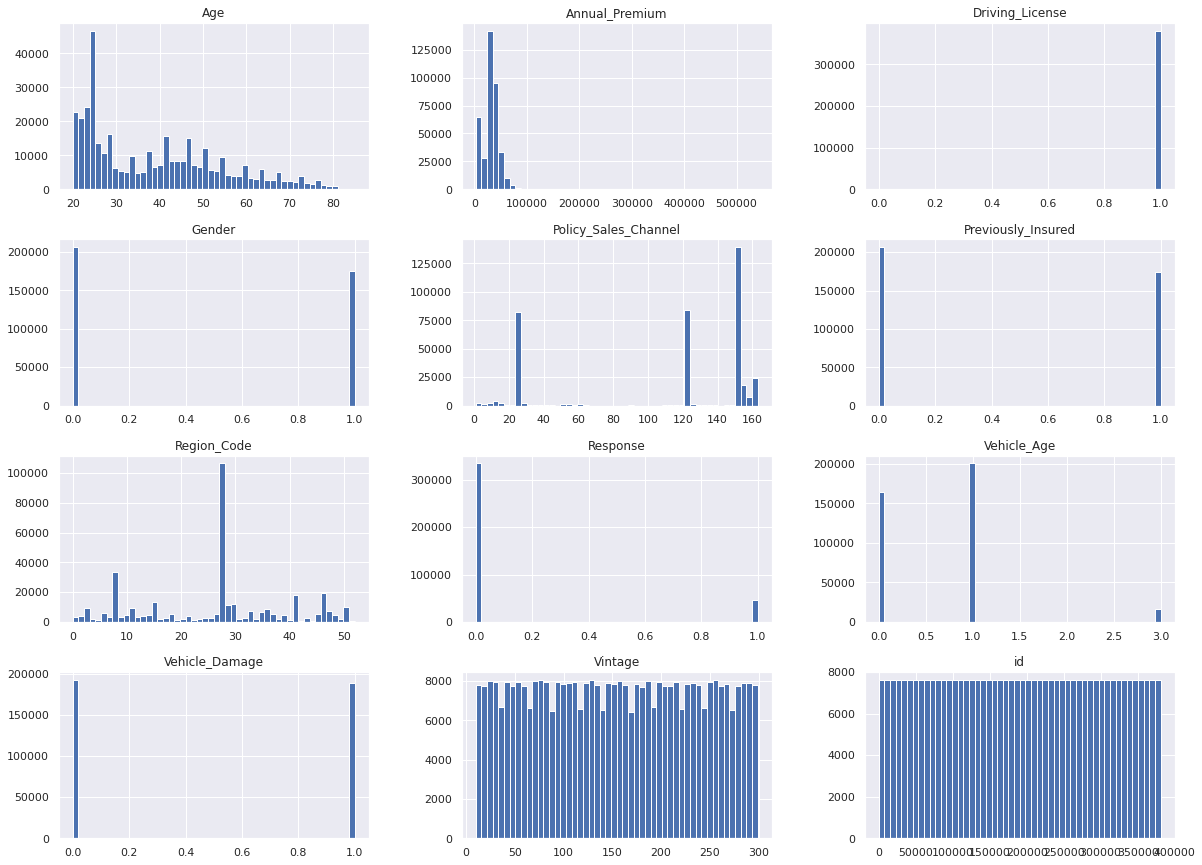

In [182]:
%matplotlib inline
import matplotlib.pyplot as plt
train.hist(bins=50, figsize=(20,15))
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdaa154afd0>,
      dtype=object)

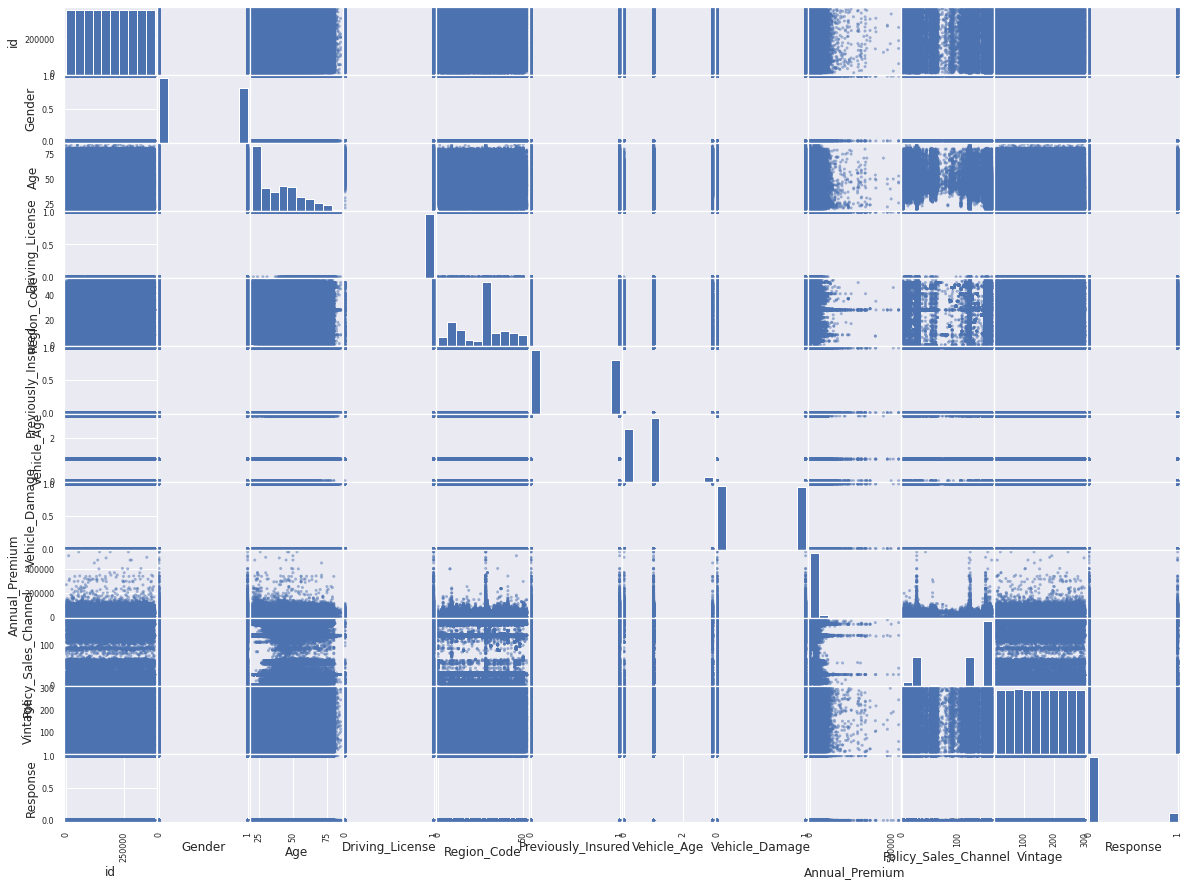

In [183]:
from pandas.plotting import scatter_matrix
scatter_matrix(train, figsize=(20, 15))

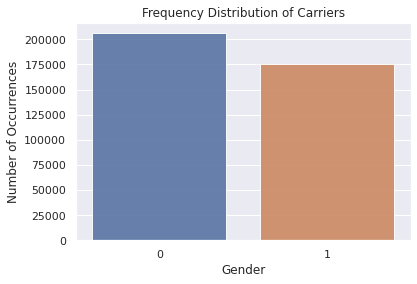

<Figure size 4320x1728 with 0 Axes>

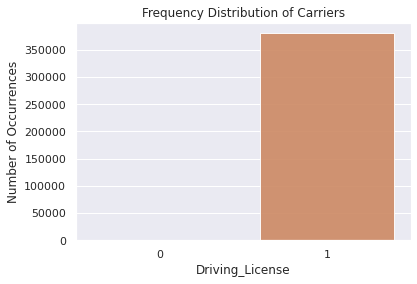

<Figure size 4320x1728 with 0 Axes>

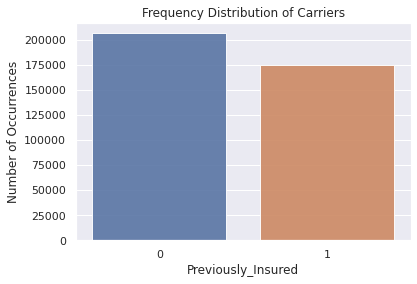

<Figure size 4320x1728 with 0 Axes>

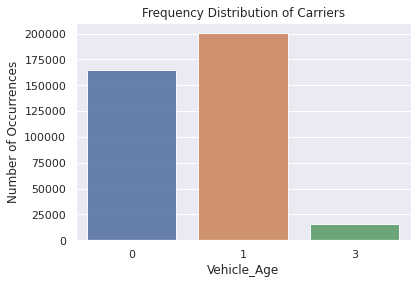

<Figure size 4320x1728 with 0 Axes>

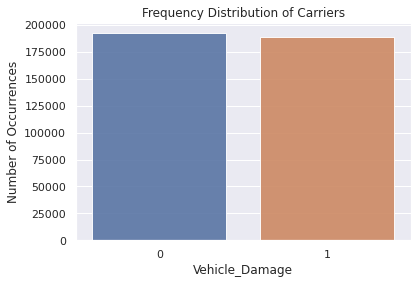

<Figure size 4320x1728 with 0 Axes>

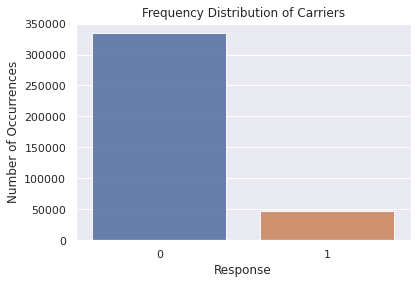

<Figure size 4320x1728 with 0 Axes>

In [184]:
for each in train.columns.to_list():
    if len(train[each].unique())<40:
        carrier_count = train[each].value_counts()
        sns.set(style="darkgrid")
        sns.barplot(carrier_count.index, carrier_count.values, alpha=0.9)
        plt.title('Frequency Distribution of Carriers')
        plt.ylabel('Number of Occurrences', fontsize=12)
        plt.xlabel(each, fontsize=12)
        plt.figure(figsize=(60,24))
        plt.show()

In [219]:
remove_outliers(train, 'Annual_Premium')

14995.0
Upper Limit:  61892.5
Lower Limit:  1912.5


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,0,44,1,28.0,0,3,0,40454.0,26.0,217,1
1,2,0,76,1,3.0,0,1,1,33536.0,26.0,183,0
2,3,0,47,1,28.0,0,3,0,38294.0,26.0,27,1
3,4,0,21,1,11.0,1,0,1,28619.0,152.0,203,0
4,5,1,29,1,41.0,1,0,1,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,26.0,1,1,1,30170.0,26.0,88,0
381105,381106,0,30,1,37.0,1,0,1,40016.0,152.0,131,0
381106,381107,0,21,1,30.0,1,0,1,35118.0,160.0,161,0
381107,381108,1,68,1,14.0,0,3,0,44617.0,124.0,74,0


In [220]:
train['Annual_Premium_log'] = np.log(train['Annual_Premium'])
test['Annual_Premium_log'] = np.log(test['Annual_Premium'])

In [221]:
remove_outliers(train, 'Age')

24.0
Upper Limit:  85.0
Lower Limit:  -11.0


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_log
0,1,0,44,1,28.0,0,3,0,40454.0,26.0,217,1,10.607921
1,2,0,76,1,3.0,0,1,1,33536.0,26.0,183,0,10.420375
2,3,0,47,1,28.0,0,3,0,38294.0,26.0,27,1,10.553049
3,4,0,21,1,11.0,1,0,1,28619.0,152.0,203,0,10.261826
4,5,1,29,1,41.0,1,0,1,27496.0,152.0,39,0,10.221796
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,26.0,1,1,1,30170.0,26.0,88,0,10.314603
381105,381106,0,30,1,37.0,1,0,1,40016.0,152.0,131,0,10.597035
381106,381107,0,21,1,30.0,1,0,1,35118.0,160.0,161,0,10.466469
381107,381108,1,68,1,14.0,0,3,0,44617.0,124.0,74,0,10.705870


In [222]:
remove_outliers(train, 'Vintage')

145.0
Upper Limit:  444.5
Lower Limit:  -135.5


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response,Annual_Premium_log
0,1,0,44,1,28.0,0,3,0,40454.0,26.0,217,1,10.607921
1,2,0,76,1,3.0,0,1,1,33536.0,26.0,183,0,10.420375
2,3,0,47,1,28.0,0,3,0,38294.0,26.0,27,1,10.553049
3,4,0,21,1,11.0,1,0,1,28619.0,152.0,203,0,10.261826
4,5,1,29,1,41.0,1,0,1,27496.0,152.0,39,0,10.221796
...,...,...,...,...,...,...,...,...,...,...,...,...,...
381104,381105,0,74,1,26.0,1,1,1,30170.0,26.0,88,0,10.314603
381105,381106,0,30,1,37.0,1,0,1,40016.0,152.0,131,0,10.597035
381106,381107,0,21,1,30.0,1,0,1,35118.0,160.0,161,0,10.466469
381107,381108,1,68,1,14.0,0,3,0,44617.0,124.0,74,0,10.705870


In [223]:
X = train.drop(columns=['Response'], axis=1)
y = train['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [224]:
sm = SMOTE(random_state = 2) 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 
  
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape)) 
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1))) 
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (455990, 12)
After OverSampling, the shape of train_y: (455990,) 

After OverSampling, counts of label '1': 227995
After OverSampling, counts of label '0': 227995


In [225]:
lr = LogisticRegression()
lr.fit(X_train_res, y_train_res)
y_pred = lr.predict(X_test)
roc_auc_score(y_test, y_pred)

0.5768451201809682

Feature: 0, Score: -0.00000
Feature: 1, Score: -0.00087
Feature: 2, Score: 0.01462
Feature: 3, Score: 0.00016
Feature: 4, Score: 0.00476
Feature: 5, Score: -0.00167
Feature: 6, Score: 0.00074
Feature: 7, Score: -0.00179
Feature: 8, Score: -0.00000
Feature: 9, Score: -0.00655
Feature: 10, Score: -0.00006
Feature: 11, Score: 0.00111


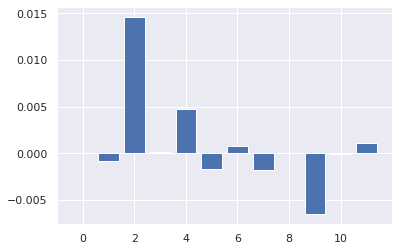

In [226]:
from matplotlib import pyplot
importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [152]:
X_train

,id,Gender,Age,Driving_License,Region_Code,Policy_Sales_Channel,Vintage,Annual_Premium_log,Previously_Insured_0,Previously_Insured_1,Vehicle_Damage_0,Vehicle_Damage_1,Vehicle_Age_0,Vehicle_Age_1,Vehicle_Age_3
68502,68503,0,0.030769,1,6.0,152.0,0.377163,10.283327,1,0,1,0,1,0,0
45697,45698,0,0.323077,1,28.0,26.0,0.878893,10.102174,1,0,1,0,0,1,0
40605,40606,0,0.015385,1,17.0,160.0,0.276817,10.470476,0,1,0,1,1,0,0
221496,221497,0,0.076923,1,8.0,152.0,0.778547,10.880177,1,0,1,0,1,0,0
48532,48533,0,0.369231,1,8.0,124.0,0.058824,10.654951,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150857,150858,0,0.923077,1,8.0,26.0,0.612457,7.874739,0,1,0,1,0,1,0
375586,375587,1,0.169231,1,28.0,156.0,0.100346,7.874739,1,0,1,0,0,1,0
378588,378589,1,0.076923,1,35.0,152.0,0.197232,10.390318,0,1,0,1,1,0,0
111980,111981,0,0.107692,1,28.0,152.0,0.262976,10.041770,0,1,0,1,1,0,0
